<a href="https://colab.research.google.com/github/T-Trolley/CO3519_Assignment2_Model/blob/main/Assignment2Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import random
from PIL import Image
from torchvision.io import read_image
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -u -q "/content/gdrive/MyDrive/ISIC2018_Task3_Training_Input.zip"

In [ ]:
!unzip -u -q "/content/gdrive/MyDrive/ISIC2018_Task3_Validation_Input.zip"

In [ ]:
!unzip -u -q "/content/gdrive/MyDrive/ISIC2018_Task3_Test_Input.zip"

In [ ]:
class ReadDataset(data.Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1:].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label


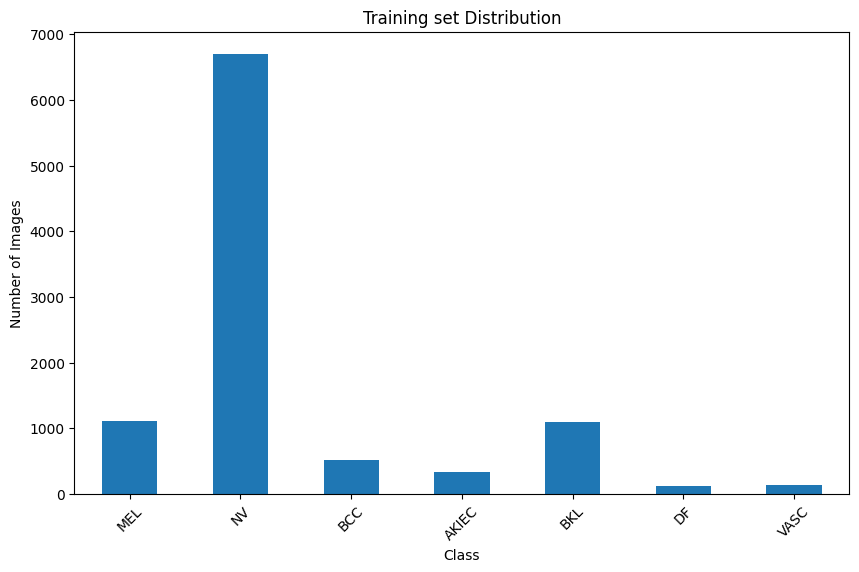

In [ ]:
# Read the CSV file
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
ground_truth = pd.read_csv(train_annotations_file)

class_distribution = ground_truth.drop(columns=['image']).sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Training set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

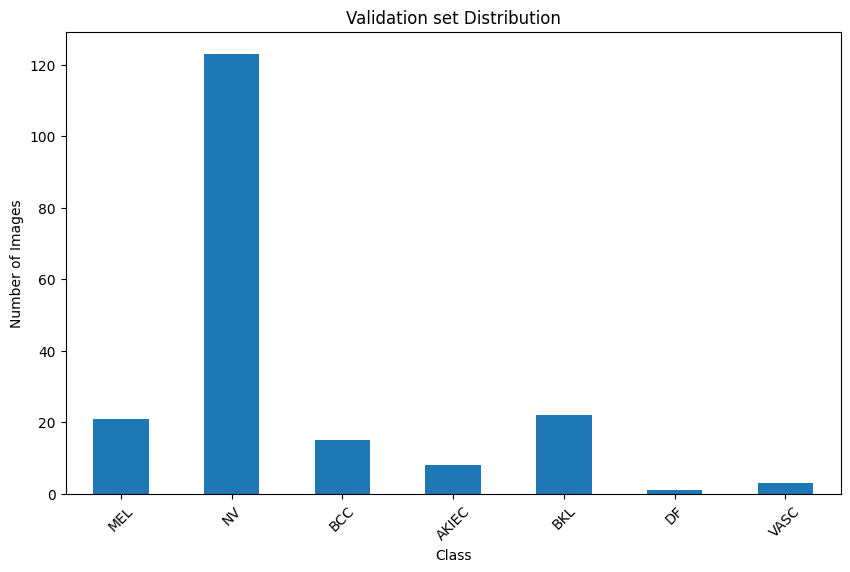

In [ ]:
# Read the CSV file
valid_annotations_file = "ISIC2018_Task3_Validation_GroundTruth.csv"
ground_truth = pd.read_csv(valid_annotations_file)

class_distribution = ground_truth.drop(columns=['image']).sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Validation set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

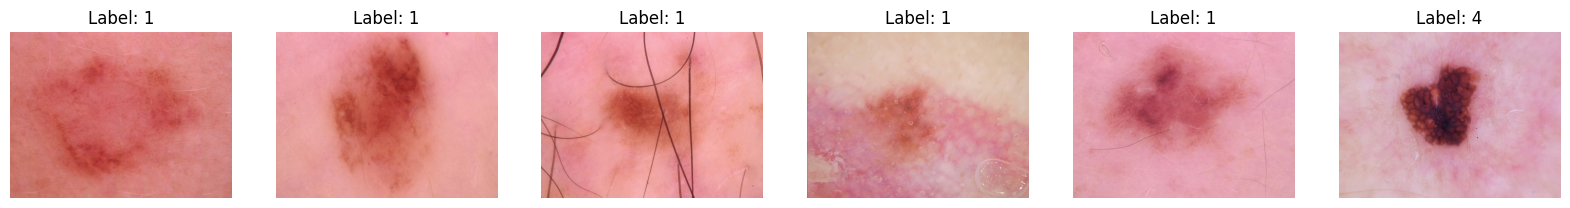

In [ ]:
# Training set
train_img_dir = "ISIC2018_Task3_Training_Input"
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
train_dataset = ReadDataset(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transforms.ToTensor())

def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    indices = random.sample(range(len(dataset)), num_images)
    for i, ax in enumerate(axes.flat):
        image, label = dataset[indices[i]]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
show_images(train_dataset, num_images=6)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Training set
train_img_dir = "ISIC2018_Task3_Training_Input"
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
train_dataset = ReadDataset(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transform)

# Validation set
valid_img_dir = "ISIC2018_Task3_Validation_Input"
valid_annotations_file = "ISIC2018_Task3_Validation_GroundTruth.csv"
valid_dataset = ReadDataset(img_dir=valid_img_dir, annotations_file=valid_annotations_file, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the model, criterion, and optimizer as before
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes for ISIC2018
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=10):
    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}')

        if val_loss < best_loss:
            print(f'Validation loss decreased from {best_loss} to {val_loss}. Saving model...')
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

In [ ]:
# Do not change it to True until you want to retrain the network.
Train_mode = False
if Train_mode:
    train_model(model, criterion, optimizer, train_loader, valid_loader)

Epoch 1, Train Loss: 1.332599751651287, Val Loss: 0.9075644612312317
Validation loss decreased from inf to 0.9075644612312317. Saving model...
Epoch 2, Train Loss: 0.6835263550281525, Val Loss: 0.6107107400894165
Validation loss decreased from 0.9075644612312317 to 0.6107107400894165. Saving model...
Epoch 3, Train Loss: 0.48564929366111753, Val Loss: 0.5537006855010986
Validation loss decreased from 0.6107107400894165 to 0.5537006855010986. Saving model...
Epoch 4, Train Loss: 0.3659710966050625, Val Loss: 0.5211806893348694
Validation loss decreased from 0.5537006855010986 to 0.5211806893348694. Saving model...
Epoch 5, Train Loss: 0.2698553655296564, Val Loss: 0.493466317653656
Validation loss decreased from 0.5211806893348694 to 0.493466317653656. Saving model...
Epoch 6, Train Loss: 0.19444320928305386, Val Loss: 0.4813985228538513
Validation loss decreased from 0.493466317653656 to 0.4813985228538513. Saving model...
Epoch 7, Train Loss: 0.13620910942554473, Val Loss: 0.496554136

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

In [ ]:
# test set
test_img_dir = "ISIC2018_Task3_Test_Input"
test_annotations_file = "ISIC2018_Task3_Test_GroundTruth.csv"
test_dataset = ReadDataset(img_dir=test_img_dir, annotations_file=test_annotations_file, transform=transform)

# Data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def evaluate_model(model, data_loader):
    true_labels = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

true_labels, predictions = evaluate_model(model, test_loader)

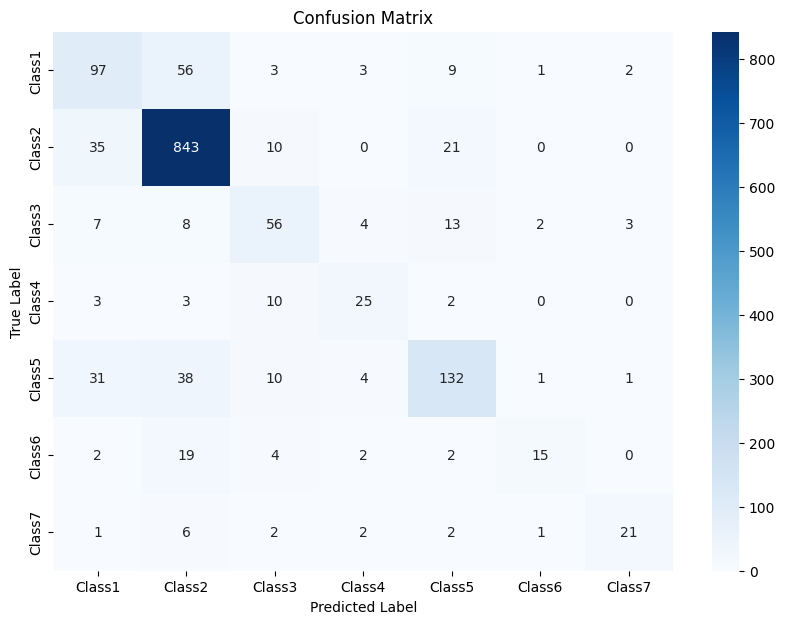

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

cm = confusion_matrix(true_labels, predictions)
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7']

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

In [ ]:
probabilities = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = 7
y_test = label_binarize(test_dataset.img_labels.iloc[:, 1:].values, classes=range(n_classes))
y_score = np.array(probabilities)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


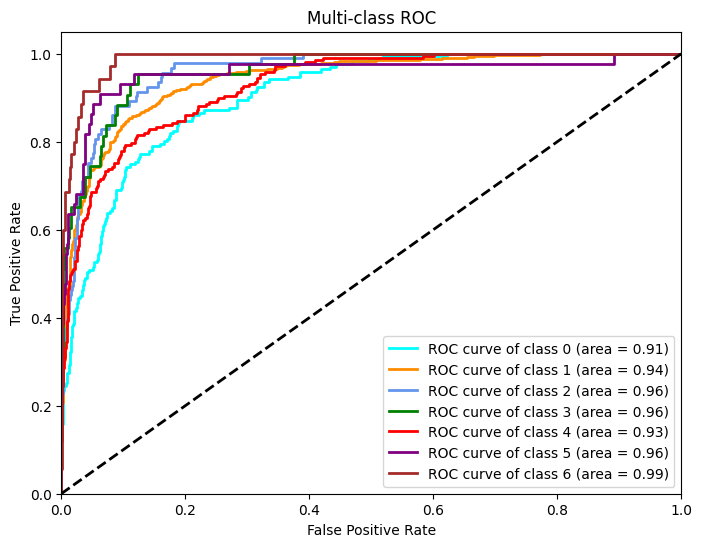

In [ ]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()